In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
import matplotlib.patches as mpatches
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import warnings
import itertools
import numpy as np
import pandas as pd
from scipy import stats
from pyfish import fish_plot, process_data
# local import
from utils import read_mi, enrichment
from utils import ml_metrics, get_rbd_mutated
from utils import AFFINITY, ESCAPE, MOI

In [3]:
df = []
d_mutated = {}
all_mutated = set()
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        df.append(read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated.tsv.gz',
                          name,
                          date=True))
        mutated = get_rbd_mutated('../out/time-filtered-lineages/',
                                  names=[name,])
        d_mutated[name] = mutated.union(all_mutated)
        all_mutated = mutated.union(all_mutated)
    except FileNotFoundError:
        pass
df = pd.concat(df)

In [4]:
df[(df['gene_source'] == 'S') & (df['gene_target'] == 'S')].groupby('name')['pos_source'].nunique()

name
2020-03    530
2020-04    392
2020-05    264
2020-06    256
2020-07    137
2020-08    161
2020-09    237
2020-10    184
2020-11    268
2020-12    289
2021-01    337
2021-02    207
2021-03    147
2021-04    142
2021-05    207
2021-06    139
2021-07    164
2021-08    138
2021-09    126
2021-10     79
2021-11     74
2021-12    175
2022-01    147
2022-02    112
2022-03     97
2022-04     73
2022-05     58
2022-06     56
2022-07     57
2022-08     56
2022-09     54
2022-10     74
2022-11     72
2022-12     68
2023-01     81
2023-02     88
2023-03     96
Name: pos_source, dtype: int64

In [5]:
df['name'].unique()

array(['2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
       '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
       '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
       '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02',
       '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
       '2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
       '2023-03'], dtype=object)

In [6]:
res = []
for name in sorted(df['name'].unique()):
    print(name)
    p = pd.read_csv(f'../out/spikes/{name}.EC.gz', sep=' ', header=None)
    p.columns = ['pos_source', 'base_source',
                 'pos_target', 'base_target',
                 '_', 'plmc']
    m = df[df['name'] == name].copy()
    m = m[(m['gene_source'] == 'S') & (m['gene_target'] == 'S')].copy()
    m['pos_source'] = m['pos_source'] - 21562
    m['pos_target'] = m['pos_target'] - 21562
    m = m.set_index(['pos_source', 'pos_target'])
    t = [name, m.shape[0], m['mi'].max(), m['mi'].min(),
         p.shape[0], p['plmc'].max(), p['plmc'].min()]
    p = p.set_index(['pos_source', 'pos_target'])
    
    idx = m.index.intersection(p.index)
    
    av = m.loc[idx]['mi']
    sv = p.loc[idx]['plmc']

    lr = stats.linregress(av, sv)

    t.extend([av.max(), av.max() / m['mi'].max(),
              sv.max(), sv.max() / p['plmc'].max(),
              len(idx), len(idx) / m.shape[0], len(idx) / p.shape[0],
              lr.rvalue])
    res.append(t)
r = pd.DataFrame(res,
                 columns=['name', 'num_mi',
                          'max_mi', 'min_mi',
                          'num_plmc',
                          'max_plmc', 'min_plmc',
                          'max_shared_mi',
                          'max_frac_shared_mi',
                          'max_shared_plmc',
                          'max_frac_shared_plmc',
                          'num_shared',
                          'frac_shared_mi',
                          'frac_shared_plmc',
                          'r'
                          ])

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


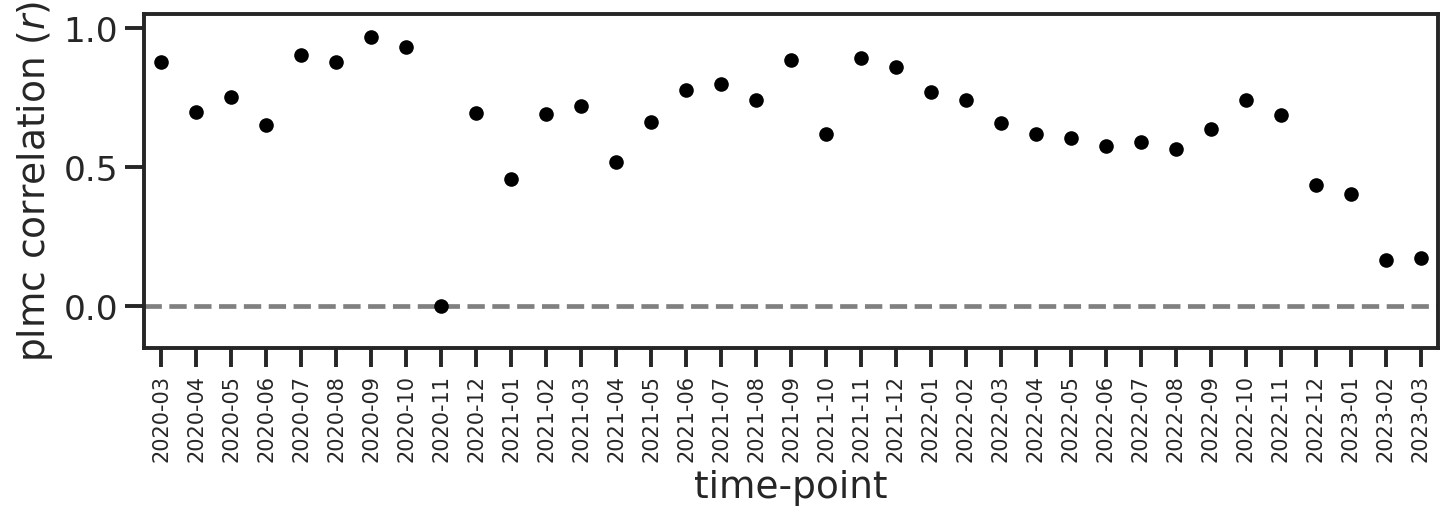

In [7]:
sns.catplot(data=r,
            x='name',
            y='r',
            color='k',
            size=7,
            height=3.5, aspect=3)

plt.xticks(size=10, rotation=90)
sns.despine(top=False, right=False)
plt.axhline(0, ls='dashed',
            color='grey')
plt.ylim(-0.15, 1.05)
plt.xlabel('time-point')
plt.ylabel('plmc correlation ($r$)')

plt.savefig('plmc_correlation_1.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('plmc_correlation_1.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);